<a href="https://colab.research.google.com/github/sayid-alt/sentiment-analysis-nlp/blob/main/Sentiment_analyst_prediction_with_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

dataset: [kaggle](https://www.kaggle.com/datasets/damirolejar/sentiment-analysis-nlp-trainset-data?select=final_negative.txt)

See copied project on [github](https://github.com/sayid-alt/sentiment-analysis-nlp)

# Import library

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Embedding, Flatten, Dropout
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, precision_score, recall_score, precision_recall_curve

from google.colab import files

import os
import zipfile
import urllib.request

# Utilities

In [2]:
DOWNLOAD_URL = 'https://github.com/sayid-alt/sentiment-analysis-nlp/raw/main/data/text.zip'
DOWNLOAD_DIR = os.path.join(os.getcwd(), 'datasets')

def download_data(url=DOWNLOAD_URL, dir=DOWNLOAD_DIR):
    # Downloading data
    print('Downloading data...')
    if not os.path.exists(dir):
        os.makedirs(dir)

    zip_path = os.path.join(dir, 'text.zip')
    urllib.request.urlretrieve(url, zip_path)
    print(f'Success downloading data to {zip_path}')

    # Extract zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dir)
        print(f'Success extracting data to {dir}')


# prep data from text file to variable in list type
def prep_data_txt(filepath):
  '''
    filepath: path for text file
    return: list of text
  '''
  datalist = []
  with open(filepath, 'r') as file:
    lines = file.readlines()
    for line in lines:
      datalist.append(line.strip())
  return datalist


# retrieve data
def retrieve_sentiment_data():
  '''
    return: neg_text, pos_text, ne_text as the dataset for sentiment analysis
  '''
  neg_text = prep_data_txt(os.path.join(data_dir, 'final_negative.txt')) #negative data
  pos_text = prep_data_txt(os.path.join(data_dir, 'final_positive.txt'))# positif data
  ne_text = prep_data_txt(os.path.join(data_dir, 'final_neutral.txt'))

  print(f'Negative data length: {len(neg_text)}')
  print(f'Positive data length: {len(pos_text)}')
  print(f'neutral data length: {len(ne_text)}')

  print(f'Negative data sample: {neg_text[:5]}')
  print(f'Positive data sample: {pos_text[:5]}')
  print(f'neutral data sample: {ne_text[:5]}')

  return neg_text, pos_text, ne_text


def stratified_split(df):
  # split data using stratified with size train/val/test 80/10/10 respectively
  df_train, df_test = train_test_split(df,
                                       test_size=0.2,
                                       random_state=42,
                                       stratify=df['label'])


  # split throug test size for get validation split
  df_val, df_test = train_test_split(df_test,
                                     test_size=0.5,
                                     random_state=42,
                                     stratify=df_test['label'])

  value_count = df['label'].value_counts()
  train_count = df_train['label'].value_counts()
  val_count = df_val['label'].value_counts()
  test_count = df_test['label'].value_counts()

  print(f'Value count:\n{value_count}')
  print(f'-----------\nTrain count:\n{train_count}')
  print(f'Val count:\n{val_count}')
  print(f'Test count:\n{test_count}')

  return df_train, df_val, df_test

def check_distribution(labels,
                       title=None,
                       xlabel='Labels',
                       ylabel='Frequency'
                       ):
  plt.figure(figsize=(5, 4))
  sns.histplot(labels, bins=3, color='skyblue')
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

def check_split_distribution(labels):
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

  for i, label in enumerate(labels):
    label.hist(ax=ax[i], bins=3, color='skyblue')
    ax[i].set_xlabel('Labels')
    ax[i].set_ylabel('Frequency')
  plt.show()



# Download data

In [3]:
download_data()

Success downloading data to /content/datasets/text.zip
Success extracting data to /content/datasets


# Generate Data

In [4]:
data_dir = os.path.join(DOWNLOAD_DIR, 'text')
print(os.listdir(data_dir))

['final_positive.txt', 'final_neutral.txt', 'final_negative.txt']


In [5]:
neg_text, pos_text, ne_text = retrieve_sentiment_data()

Negative data length: 99999
Positive data length: 100000
neutral data length: 99999
Negative data sample: ['Mothers will not give their sons as sacrifices upon the battlefield after twenty years of anxiety and loving devotion in rearing them from infancy, no matter what cause they are called upon to defend.', 'That which was meant to be conducive to life has become the cause of death; that which should have been an evidence of knowledge is now a proof of ignorance; that which was a factor in the sublimity of human nature has proved to be its degradation.', 'The Jews were expecting the appearance of the Messiah, looking forward to it with devotion of heart and soul, but because they were submerged in imitations, they did not believe in Jesus Christ when He appeared.', 'We have forsaken the path of God; we have given up attention to the divine Kingdom; we have not severed the heart from worldly attractions; we have become defiled with qualities which are not praiseworthy in the sight of 

# Data Preprocessing

## Distribution

Below we merge all data into 3 sentiment categories:
- 0: Negative sentiment
- 1: Positif sentiment
- 2: neutral sentimen

In [6]:
df = pd.DataFrame({
    'sentiment' : neg_text + pos_text + ne_text,
    'label' : ['negative'] * len(neg_text) + ['positive'] * len(pos_text) + ['neutral'] * len(ne_text)
})
df.head()

,sentiment,label
0,Mothers will not give their sons as sacrifices...,negative
1,That which was meant to be conducive to life h...,negative
2,The Jews were expecting the appearance of the ...,negative
3,We have forsaken the path of God; we have give...,negative
4,"Sixth, the Messiah was to gather together all ...",negative


In [ ]:
check_distribution(df['label'], 'Distribution of Sentiment Labels')

## Split data

Split data, using stratified shuffle split from sklearn []:
- Train: 80
- Val: 10
- test: 10

In [ ]:
# split data using stratified with size train/val/test 80/10/10 respectively
df_train, df_val, df_test = stratified_split(df)

In [ ]:
df_train.head(), df_val.head(), df_test.head()

## Checking for split distribution

In [ ]:

dfs_label = [df_train['label'], df_val['label'], df_test['label']]

check_split_distribution(dfs_label)

In [ ]:
# check the size of each split
len_df = len(df)
len_train = len(df_train)
len_val = len(df_val)
len_test = len(df_test)

print(f'Train data size: {round(len_train/len_df,2)}')
print(f'Val data size: {round(len_val/len_df,2)}')
print(f'Test data size: {round(len_test/len_df,2)}')

In [ ]:
split_name = ['train', 'val', 'test']
split_df = [len_train, len_val, len_test]

plt.figure(figsize=(5, 4))
bars = plt.bar(x=split_name, height=split_df, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height - (height/2.0), '%0.2f%s' % ((height/len_df)*100, '%'), ha='center', va='bottom', color='teal')

plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

## Preparation for training

In [ ]:
# split for training portion
X_train, y_train = df_train['sentiment'], df_train['label']
X_val, y_val = df_val['sentiment'], df_val['label']
X_test, y_test = df_test['sentiment'], df_test['label']

In [ ]:
# X_train.to_csv('X_train.csv', index=False)
# y_train.to_csv('y_train.csv', index=False)
# X_val.to_csv('X_val.csv', index=False)
# y_val.to_csv('y_val.csv', index=False)
# X_test.to_csv('X_test.csv', index=False)
# y_test.to_csv('y_test.csv', index=False)


In [ ]:
# try:
#   from google.colab import files
# except e:
#   print(e)
# else:
#   files.download('X_train.csv')
#   files.download('y_train.csv')
#   files.download('X_val.csv')
#   files.download('y_val.csv')
#   files.download('X_test.csv')
#   files.download('y_test.csv')

### Hyperparameters

In [ ]:
# Vocabulary size of the tokenizer
vocab_size = 10000

# Maximum length of the padded sequences
max_length = 50

# Output dimensions of the Embedding layer
embedding_dim = 16

### Tokenize data

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [ ]:
print(len(word_index))

In [ ]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y_train)
label_index_word = label_tokenizer.index_word

# start encoder label from 0
labels_encoder = {key - 1: value for key, value in label_index_word.items()}

# Tokenize the label
training_labels = label_tokenizer.texts_to_sequences(y_train)
val_labels = label_tokenizer.texts_to_sequences(y_val)
test_labels = label_tokenizer.texts_to_sequences(y_test)

In [ ]:
print(labels_encoder)
np.unique(y_test)

In [ ]:
# convert labels list to np array
# Below arrays are subtracted by one, because all index should start from 0, instead the current label before subtract started with one
training_labels = np.array(training_labels) - 1
val_labels = np.array(val_labels) - 1
test_labels = np.array(test_labels) - 1

In [ ]:
print(f'label training shape\t : {training_labels.shape}')
print(f'label val shape\t\t : {val_labels.shape}')
print(f'label test shape\t : {test_labels.shape}')

### Sequence data

In [ ]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

### padded data

In [ ]:
padded_train = pad_sequences(sequences_train, maxlen=max_length, truncating='post', padding='post')
padded_val = pad_sequences(sequences_val, maxlen=max_length, truncating='post', padding='post')
padded_test = pad_sequences(sequences_test,maxlen=max_length, truncating='post', padding='post')

In [ ]:
print(padded_train[0], padded_train.shape)
print(padded_val.shape)
print(padded_test.shape)

# Build and compile Model

In [ ]:
model = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.summary()

In [ ]:

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],
              )

# Set Callbacks

In [ ]:
# early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                                                  mode='min',
                                                  patience=5, restore_best_weights=True)



# Model checkpoint, saving the best only val_acc

checkpoint_filepath = '/tmp/ckpt/checkpoint-{epoch:02d}-{accuracy:.3f}-{val_accuracy:.3f}.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False,
    verbose=1)

csv_logger = CSVLogger('training.log')

# START TRAINING HERE, BE CAREFUL TO RUN CELL BELOW

# Model training

In [29]:
num_epochs=30
history = model.fit(padded_train, training_labels, epochs=num_epochs,
                    validation_data=(padded_val, val_labels), verbose=2,
                    callbacks=[early_stopping, model_checkpoint_callback, csv_logger]
                    )

Epoch 1/30

Epoch 1: saving model to /tmp/ckpt/checkpoint-01-0.731-0.788.keras
7500/7500 - 18s - 2ms/step - accuracy: 0.7307 - loss: 0.6310 - val_accuracy: 0.7877 - val_loss: 0.5053
Epoch 2/30

Epoch 2: saving model to /tmp/ckpt/checkpoint-02-0.797-0.788.keras
7500/7500 - 16s - 2ms/step - accuracy: 0.7966 - loss: 0.5090 - val_accuracy: 0.7878 - val_loss: 0.4945
Epoch 3/30

Epoch 3: saving model to /tmp/ckpt/checkpoint-03-0.804-0.789.keras
7500/7500 - 21s - 3ms/step - accuracy: 0.8042 - loss: 0.4888 - val_accuracy: 0.7886 - val_loss: 0.4990
Epoch 4/30

Epoch 4: saving model to /tmp/ckpt/checkpoint-04-0.808-0.790.keras
7500/7500 - 22s - 3ms/step - accuracy: 0.8075 - loss: 0.4774 - val_accuracy: 0.7901 - val_loss: 0.5005
Epoch 5/30

Epoch 5: saving model to /tmp/ckpt/checkpoint-05-0.810-0.790.keras
7500/7500 - 19s - 3ms/step - accuracy: 0.8099 - loss: 0.4684 - val_accuracy: 0.7905 - val_loss: 0.5024
Epoch 6/30

Epoch 6: saving model to /tmp/ckpt/checkpoint-06-0.813-0.785.keras
7500/7500 -

# Visualize the results

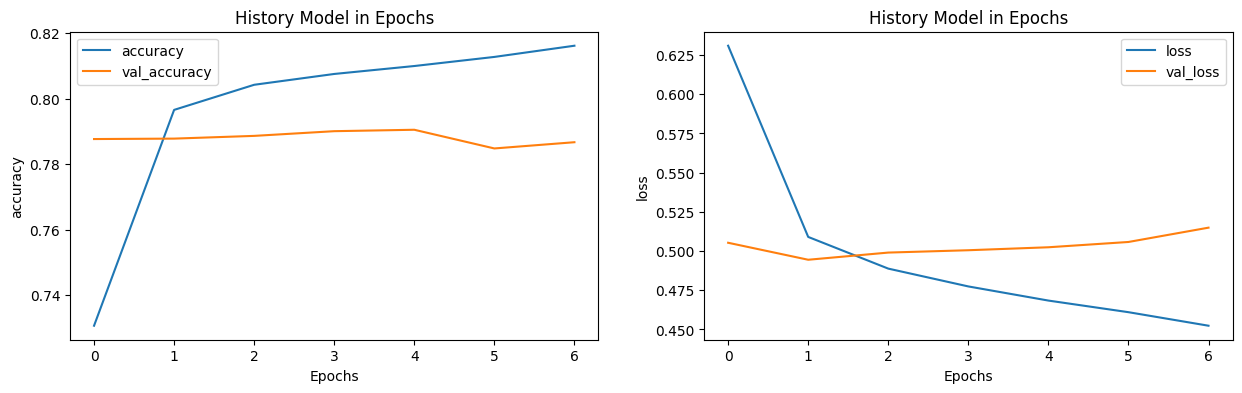

In [30]:
# Plot utility
def plot_graphs(history, strings=['accuracy', 'loss']):
  fig, ax = plt.subplots(figsize=(15, 4), nrows=1, ncols=2)

  for i, string in enumerate(strings):
    ax[i].plot(history.history[string])
    ax[i].plot(history.history['val_'+string])

    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(string)
    ax[i].legend([string, 'val_'+string])
    ax[i].set_title('History Model in Epochs')

  plt.show()

# Plot the accuracy and loss
plot_graphs(history)

# Saving best checkpoint model

In [31]:
!zip -r ckpt.zip /tmp/ckpt
models_to_download = 'ckpt.zip'
try:
  files.download('training.log')
  files.download(models_to_download)

except e:
  print(e)

  adding: tmp/ckpt/ (stored 0%)
  adding: tmp/ckpt/checkpoint-07-0.816-0.787.keras (deflated 8%)
  adding: tmp/ckpt/checkpoint-04-0.808-0.790.keras (deflated 8%)
  adding: tmp/ckpt/checkpoint-02-0.797-0.788.keras (deflated 8%)
  adding: tmp/ckpt/checkpoint-06-0.813-0.785.keras (deflated 8%)
  adding: tmp/ckpt/checkpoint-05-0.810-0.790.keras (deflated 8%)
  adding: tmp/ckpt/checkpoint-03-0.804-0.789.keras (deflated 8%)
  adding: tmp/ckpt/checkpoint-01-0.731-0.788.keras (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# END TRAINING HERE, BE CAREFUL TO RUN CELLS ABOVE

# Evaluate the model

In [29]:
def download_model():
  model_url = 'https://github.com/sayid-alt/sentiment-analysis-nlp/raw/main/model/ckpt/ckpt/checkpoint-07-0.815-0.788.keras'
  # Find the position of the last forward slash '/'
  last_slash_index = model_url.rfind('/')

  # Extract the substring from the last slash to the end of the string
  model_name = model_url[last_slash_index + 1:]
  urllib.request.urlretrieve(model_url, model_name)
  print('Downloading model...')
  print('Success downloading model')
  return model_name

model_name = download_model()

Success downloading model


In [30]:
# loaded trained model
loaded_model = tf.keras.models.load_model(model_name)

In [31]:
loss, accuracy = loaded_model.evaluate(padded_test, test_labels)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7906 - loss: 0.5001
Loss: 0.5052914023399353
Accuracy: 0.791366696357727


## Prediction

In [32]:
# predict the test labels from dataset

# show prediction softmax probability
predictions = loaded_model.predict(padded_test)
print(predictions)

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
[[7.9157522e-05 1.9315179e-01 8.0676907e-01]
 [3.0753844e-10 3.5775357e-04 9.9964225e-01]
 [3.5030367e-05 3.9485773e-01 6.0510719e-01]
 ...
 [1.0000000e+00 2.2408731e-08 8.2101644e-16]
 [1.0865953e-01 1.9765829e-01 6.9368225e-01]
 [2.3168121e-01 3.1817707e-01 4.5014173e-01]]


## Confussion Matrix

In [33]:
labels_encoder

{0: 'positive', 1: 'neutral', 2: 'negative'}

In [34]:
np.unique(test_labels)

array([0, 1, 2])

In [36]:
# Return the highest softmax prob index
pred_labels = np.argmax(predictions, axis=1)
print(f'pred labels: {pred_labels[:5]}')
print(f'test labels: {test_labels[:5]}')

con_mat = tf.math.confusion_matrix(labels=test_labels, predictions=pred_labels).numpy()
con_mat

pred labels: [2 2 2 0 2]
test labels: [[2]
 [2]
 [1]
 [0]
 [2]]


array([[8669,  890,  441],
       [1476, 6561, 1963],
       [ 398, 1091, 8511]], dtype=int32)

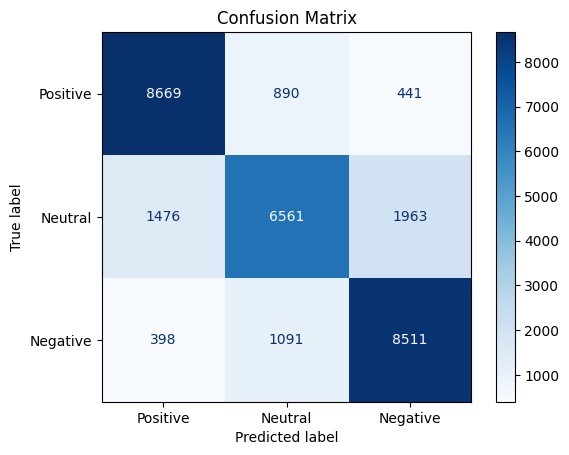

In [37]:
con_mat_disp = ConfusionMatrixDisplay(con_mat, display_labels=['Positive','Neutral', 'Negative'])
con_mat_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Precision, Recall, F1 score

In [38]:
precision_score = precision_score(test_labels, pred_labels, average='macro')
recall_score = recall_score(test_labels, pred_labels, average='macro')
f1_score = f1_score(test_labels, pred_labels, average='macro')

In [39]:

print(f'Precision Score: {precision_score}')
print(f'Recall Score: {recall_score}')
print(f'F1 Score: {f1_score}')

Precision Score: 0.7900304880121048
Recall Score: 0.7913666666666668
F1 Score: 0.7885140269451861


In [41]:
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Assuming test_labels and predictions are given
# test_labels: Actual labels (e.g., [0, 1, 2, 0, 2])
# predictions: Predicted probabilities for each class (e.g., shape [n_samples, n_classes])

# Binarize the labels for a one-vs-rest approach
n_classes = predictions.shape[1]

#converts the original test_labels into a one-hot encoded format.
test_labels_bin = label_binarize(test_labels, classes=np.arange(n_classes))

# Store precision, recall, thresholds for each class
precision_dict = {}
recall_dict = {}
thresholds_dict = {}

for i in range(n_classes):
    precision, recall, thresholds = precision_recall_curve(test_labels_bin[:, i], predictions[:, i])
    precision_dict[i] = precision
    recall_dict[i] = recall
    thresholds_dict[i] = thresholds

# Now you have precision, recall, and thresholds for each class in the dictionaries
# For example, to access the precision for class 0:
print(f'Precision for class 0: {precision_dict[0]}')
print(f'Recall for class 0: {recall_dict[0]}')
print(f'Thresholds for class 0: {thresholds_dict[0]}')

[[0 0 1]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]] (30000, 3)
[[2]
 [2]
 [1]
 [0]
 [2]] (30000, 1)
Precision for class 0: [0.33333333 0.33334444 0.33335556 ... 1.         1.         1.        ]
Recall for class 0: [1.     1.     1.     ... 0.0258 0.0255 0.    ]
Thresholds for class 0: [9.3231365e-21 9.7536566e-21 2.9441298e-15 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


## ROC Curve

## Input user

In [ ]:
user_input = input('Enter a sentence: ')

# tokenize the sentence
user_sequence = tokenizer.texts_to_sequences([user_input])

# pad the sequence
user_padded = pad_sequences(user_sequence, maxlen=max_length, truncating='post', padding='post')

# predict the sentiment
prediction = loaded_model.predict(user_padded)

# -- - Summary prediciton ---
print('---- Prediction summary -----')
print(labels_encoder)
print('Softmax probability:', prediction)

# return the highest probability of 3 categories
predicted_index = np.argmax(prediction, axis=1)

# get the predicted label based on highest probability
predicted_label = labels_encoder[predicted_index[0]]
print(f'Predicted sentiment: {predicted_label}')

Enter a sentence: I love this sentence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
---- Prediction summary -----
{0: 'positive', 1: 'neutral', 2: 'negative'}
Softmax probability: [[0.4476304  0.3376222  0.21474741]]
Predicted sentiment: positive


# Deployment

## Using Pickle

In [ ]:
with open('model.pkl', 'wb') as file:
  pickle.dump(loaded_model, file)

In [ ]:
files.download('model.pkl')